In [1]:
from pathlib import Path
import os
compe='digit-recognizer'
iskaggle= os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if iskaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
!cd digit-recognizer; ls

sample_submission.csv test.csv              train.csv


In [3]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [5]:
df=pd.read_csv(f'{compe}/train.csv')
df_test=pd.read_csv(f'{compe}/test.csv')
df_sub=pd.read_csv(f'{compe}/sample_submission.csv')

NameError: name 'pd' is not defined

In [5]:
print('shape of train:',df.shape)
print('shape of test:',df_test.shape)

shape of train: (42000, 785)
shape of test: (28000, 784)


In [6]:
df.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.label.describe()

count   42000.00
mean        4.46
std         2.89
min         0.00
25%         2.00
50%         4.00
75%         7.00
max         9.00
Name: label, dtype: float64

In [8]:
preds=pd.DataFrame()
preds['ImageId'] = range(1, df_test.shape[0] + 1)
preds['Label']=4

In [3]:
df_test.head(2)

NameError: name 'df_test' is not defined

In [4]:
import subprocess
def make_sub(pred_y,sub_data=df_test,name='default'):
    df_submission = pd.DataFrame()
    df_submission['ImageId']=range(1, df_test.shape[0] + 1)
    df_submission['Label']=pred_y
    df_submission.to_csv(f'submission-{name}.csv', index=False)
    cmd =f'kaggle competitions submit -c {compe} -f submission-{name}.csv -m "Message"'
    subprocess.run(cmd, shell=True)
    print(f'succesully saved - {name}')

NameError: name 'df_test' is not defined

In [19]:
make_sub(preds['Label'],name='mode_model')

100%|██████████| 208k/208k [00:01<00:00, 211kB/s]  


Successfully submitted to Digit Recognizersuccesully saved - mode_model


### EDA

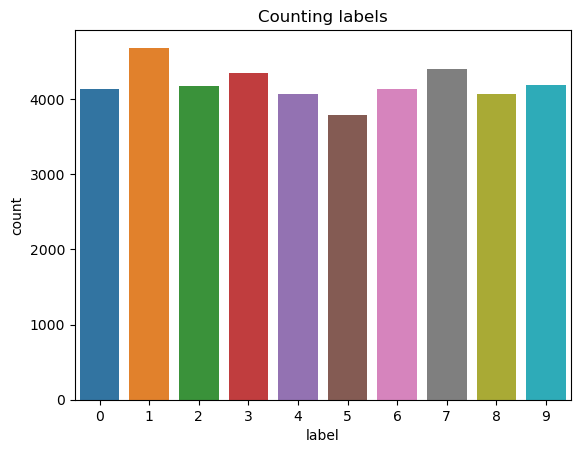

In [12]:
import seaborn as sns
sns.countplot(data=df,x='label')
plt.title('Counting labels')
plt.show()

AttributeError: 'str' object has no attribute 'squeeze'

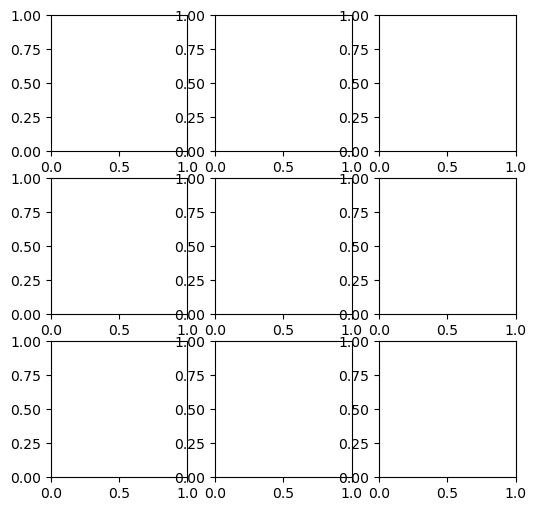

In [16]:
_,ax = plt.subplots(3,3,figsize=(6,6))
from PIL import Image
for i,( image,label) in enumerate(zip(X_train,Y_train)) :
    ax[i//3][i%3].imshow(image.squeeze())
    ax[i//3][i%3].axis('off')
    ax[i//3][i%3].set_title(f"Label: {label}",y=-0.3)
    if(i==8): break
plt.subplots_adjust(hspace=0.5)
plt.show()

In [14]:
X_train=df.copy()
X_test=df_test.copy()
Y_train=X_train['label']
X_train.drop('label',axis=1,inplace=True)

In [13]:
Y=X_train['label']
X=X_train.drop('label',axis=1,inplace=False)

In [14]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
num_cols = X.select_dtypes(include=['int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns
print(cat_cols)
print(num_cols)

Index([], dtype='object')
Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)


In [16]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
def log_transform(X):
    return np.log1p(X)

numeric_preprocessor = Pipeline(
    steps=[
#         ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
#         ("log_transform", FunctionTransformer(log_transform)),
#         ("scaler", StandardScaler()),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_constant",
            SimpleImputer(fill_value="missing", strategy="most_frequent"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [
#         ("categorical", categorical_preprocessor, cat_cols),
#         ("numerical", numeric_preprocessor,num_cols),
    ]
)

pipe = make_pipeline( RandomForestRegressor())
pipe  # click on the diagram below to see the details of each step

Pipeline(steps=[('randomforestregressor', RandomForestRegressor())])

In [36]:
pipe.fit(X,Y)

KeyboardInterrupt: 

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=10)  # Set the desired number of components
X_pca = pca.fit_transform(X_scaled)

X_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"])


In [39]:
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-5.14,-5.23,3.89,-0.90,4.93,2.03,4.71,-4.71,0.21,-1.29
1,19.29,6.03,1.31,-2.38,3.09,-1.80,-3.76,0.18,-4.15,-4.01
2,-7.64,-1.71,2.29,2.24,5.09,-4.16,-1.01,1.74,0.42,0.10
3,-0.47,5.84,2.01,4.27,2.38,2.19,4.39,-0.38,1.02,5.29
4,26.56,6.02,0.93,-3.01,9.49,-2.34,-6.15,-1.75,-4.16,-5.53


In [44]:
X_pca.shape

(42000, 10)

In [46]:
pipe.fit(X_pca,Y)

Pipeline(steps=[('randomforestregressor', RandomForestRegressor())])

In [71]:
pred_labels=pipe.predict(X_test_pca)

In [56]:
X_test_scaled = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
X_test_pca = pd.DataFrame(X_test_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"])

In [74]:
pred_labels[:10]

array([2, 0, 6, 5, 3, 7, 0, 3, 0, 3])

In [73]:
pred_labels=np.round(pred_labels).astype(int)

In [75]:
make_sub(pred_labels,name='rf_model')

100%|██████████| 208k/208k [00:00<00:00, 321kB/s] 


Successfully submitted to Digit Recognizersuccesully saved - rf_model


In [80]:
X.shape

(42000, 784)

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(X)

X_embedded = pd.DataFrame(X_embedded, columns=['TSNE_{}'.format(i+1) for i in range(10)])

print(X_embedded.head())


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: Shape of passed values is (42000, 3), indices imply (42000, 10)

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

X = X_embedded

y = df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.columns)
    ])

pipe = make_pipeline(preprocessor, XGBClassifier())

pipe.fit(X_train, y_train)

In [ ]:
# Predict on the testing data
y_pred = pipe.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)